In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import string
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud

# Twitter Sentiment Analysis
In this assignment i am going to use the dataset containing tweets about different companies/entities. It consist of 4 columns:
- `id`: tweet ID (not going to be useful in our case)
- `entity`: name of the company/entity
- `sentiment`: type of the message; possible values: Neutral, Irrelevent, Positive, Negative
- `text`: message content

*Side notes*: <br>
- original dataset was split into two separate csv files containing train and validation data. I decided to merge them to get more training samples.
- in this analysis i am going to use all possible sentiment categories (not only positive and negative tweets)
- some tweets contains swears but they are not removed becaus of their sentimental value

## Data cleaning

### Merging two datasets

In [2]:
column_names = ['id', 'entity', 'sentiment', 'text'] 
df = pd.read_csv('twitter_training.csv')
second_df = pd.read_csv('twitter_validation.csv')

df.columns = column_names
second_df.columns = column_names

df = pd.concat([df, second_df], ignore_index=True)
df.head(10)

,id,entity,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...
5,2402,Borderlands,Positive,So I spent a few hours making something for fu...
6,2402,Borderlands,Positive,So I spent a couple of hours doing something f...
7,2402,Borderlands,Positive,So I spent a few hours doing something for fun...
8,2402,Borderlands,Positive,So I spent a few hours making something for fu...
9,2402,Borderlands,Positive,2010 So I spent a few hours making something f...


In [3]:
print(df['sentiment'].unique())

['Positive' 'Neutral' 'Negative' 'Irrelevant']


> Notes: As i mentioned in the introduction, the dataset contains 4 types of sentiment

In [4]:
def prepare_review(review):
    translator = str.maketrans('', '', string.punctuation)
    final_review = review.translate(translator)
    return final_review

> Notes:
> - we need to clean the dataset from punctuation beacause is does not add anyting to a model
> - note that the function responsible for deleting punctuation also removes exclamation points
> - this procedure helps us to remove noise from our data (this would avoid situations where `word.` and `word` would be different words)

In [5]:
df['text'] = df['text'].astype(str)
df['text'] = df['text'].apply(prepare_review)

df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75680 entries, 0 to 75679
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         75680 non-null  int64 
 1   entity     75680 non-null  object
 2   sentiment  75680 non-null  object
 3   text       75680 non-null  object
dtypes: int64(1), object(3)
memory usage: 2.3+ MB


,id,entity,sentiment,text
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you all
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


> Notes:
> - as we can see our dataset does not contain any null values


## Exploring the data

### Most popular words in each sentiment category

In [6]:
def draw_wordclouds(category):
    word_cloud_text = ''.join(df[df['sentiment'] == category]['text'])
    wordcloud = WordCloud(
        max_font_size=100,
        max_words=100,
        background_color="black",
        scale=10,
        width=800,
        height=800
    ).generate(word_cloud_text)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

Most popular words in Positive category


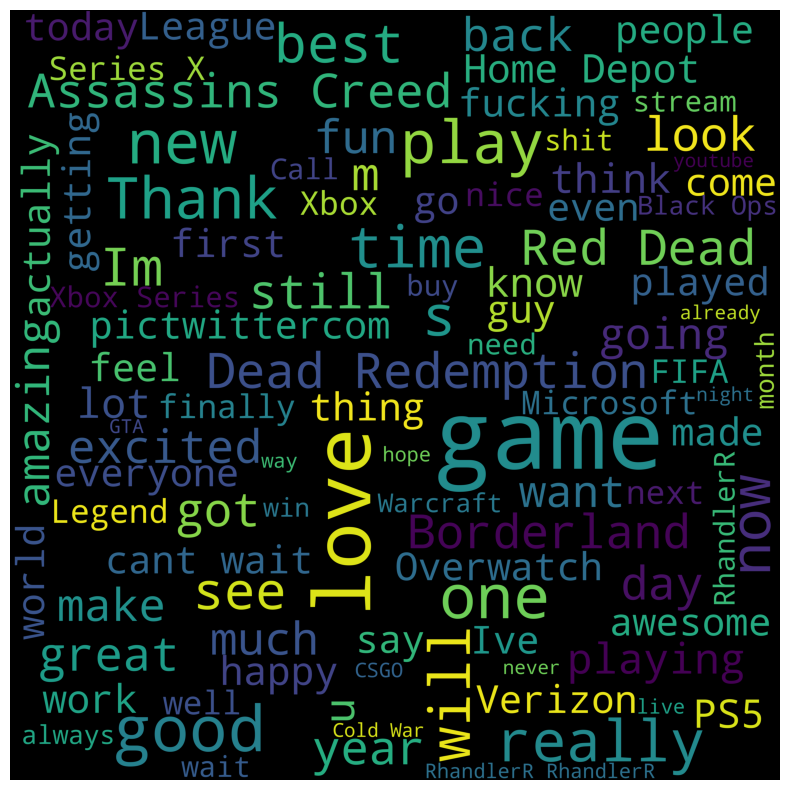

Most popular words in Neutral category


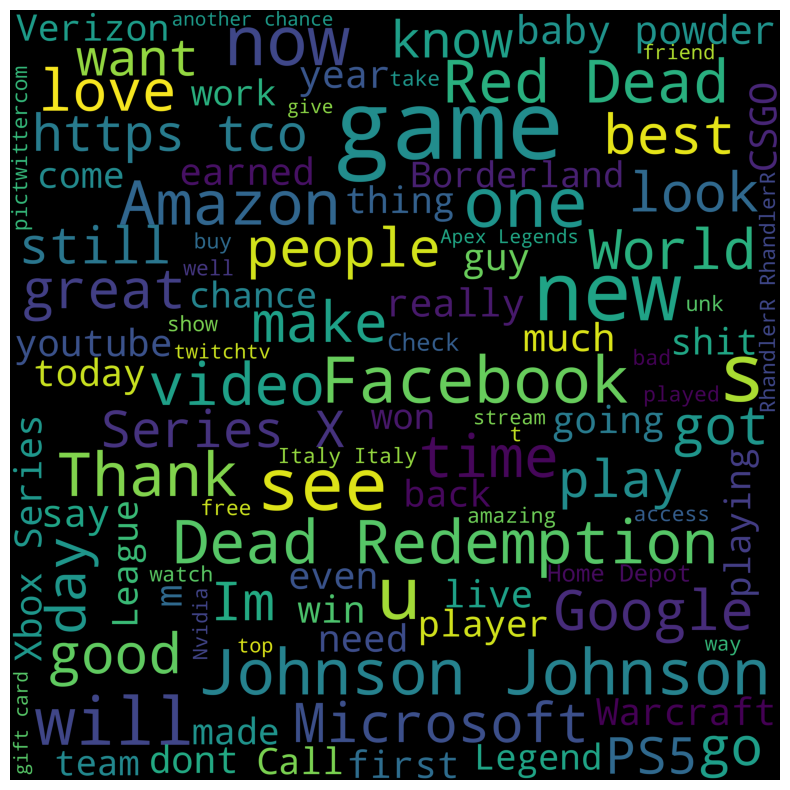

Most popular words in Negative category


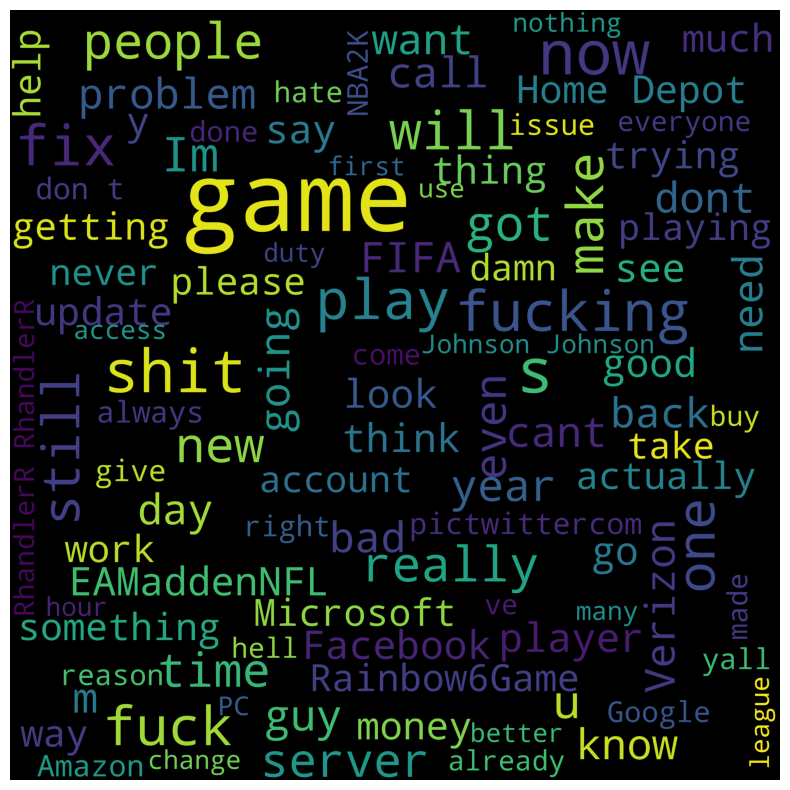

Most popular words in Irrelevant category


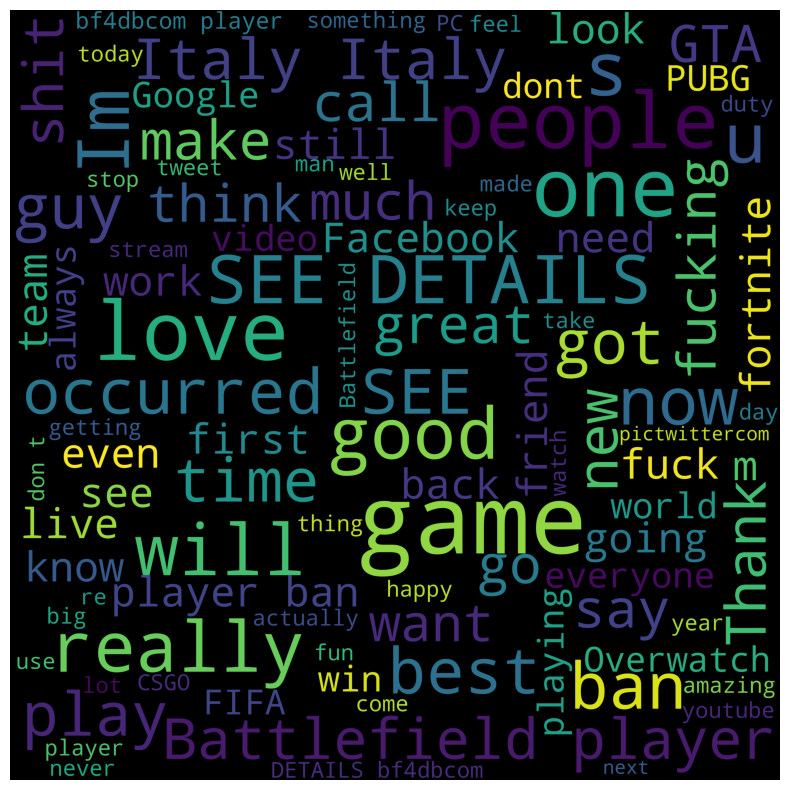

In [7]:
for category in df['sentiment'].unique():
    print(f"Most popular words in {category} category")
    draw_wordclouds(category)

> Notes:
> - observing above word clouds we can see that all of them contain similar vocabulary regardless of sentiment
> - in the negative word cloud we can spot much more swears
> - there are words like `game` that are present in all tweets
> - many words contained in the dataset do not exist (mostly they are twitter proflie names, tags or parts of unofficial vocabulary)
> - removing words that do not exist results in significant performance drops in the final models (many of these words have a sentiment attached to them)
> - the neutral category is dominated by words representing company names and products

### Percentage of messages of each sentiment

([<matplotlib.patches.Wedge at 0x7f0d72e25590>,
 [Text(-0.5715134915907518, 0.9398788905650279, 'Irrelevant'),
  Text(-0.9813892481525998, -0.49686531737531775, 'Negative'),
  Text(0.636362769829331, -0.8972415645605937, 'Neutral'),
  Text(0.8451613002779746, 0.7040613442821892, 'Positive')],
 [Text(-0.3117346317767737, 0.5126612130354697, '17%'),
  Text(-0.5353032262650543, -0.2710174458410824, '30%'),
  Text(0.3471069653614533, -0.48940448976032375, '25%'),
  Text(0.4609970728788952, 0.3840334605175577, '28%')])

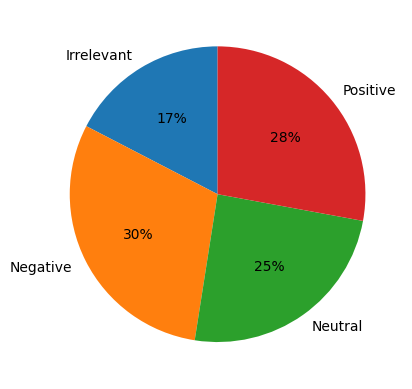

In [8]:
sentiment_groupped_df = df.groupby(by="sentiment").size().reset_index(name="count")
plt.pie(sentiment_groupped_df['count'], labels=sentiment_groupped_df['sentiment'], autopct='%.0f%%', startangle=90)

> Notes:
> - as we can see, most of the tweets fall into negative, positive and neutral categories
> - number of irrelevant messages is the smallest

### Distribution of tweets per entity and type

In [9]:
plt_df = df.groupby(by=["entity","sentiment"]).size().reset_index(name="count")
plt_df.head()

,entity,sentiment,count
0,Amazon,Irrelevant,195
1,Amazon,Negative,582
2,Amazon,Neutral,1254
3,Amazon,Positive,319
4,ApexLegends,Irrelevant,195


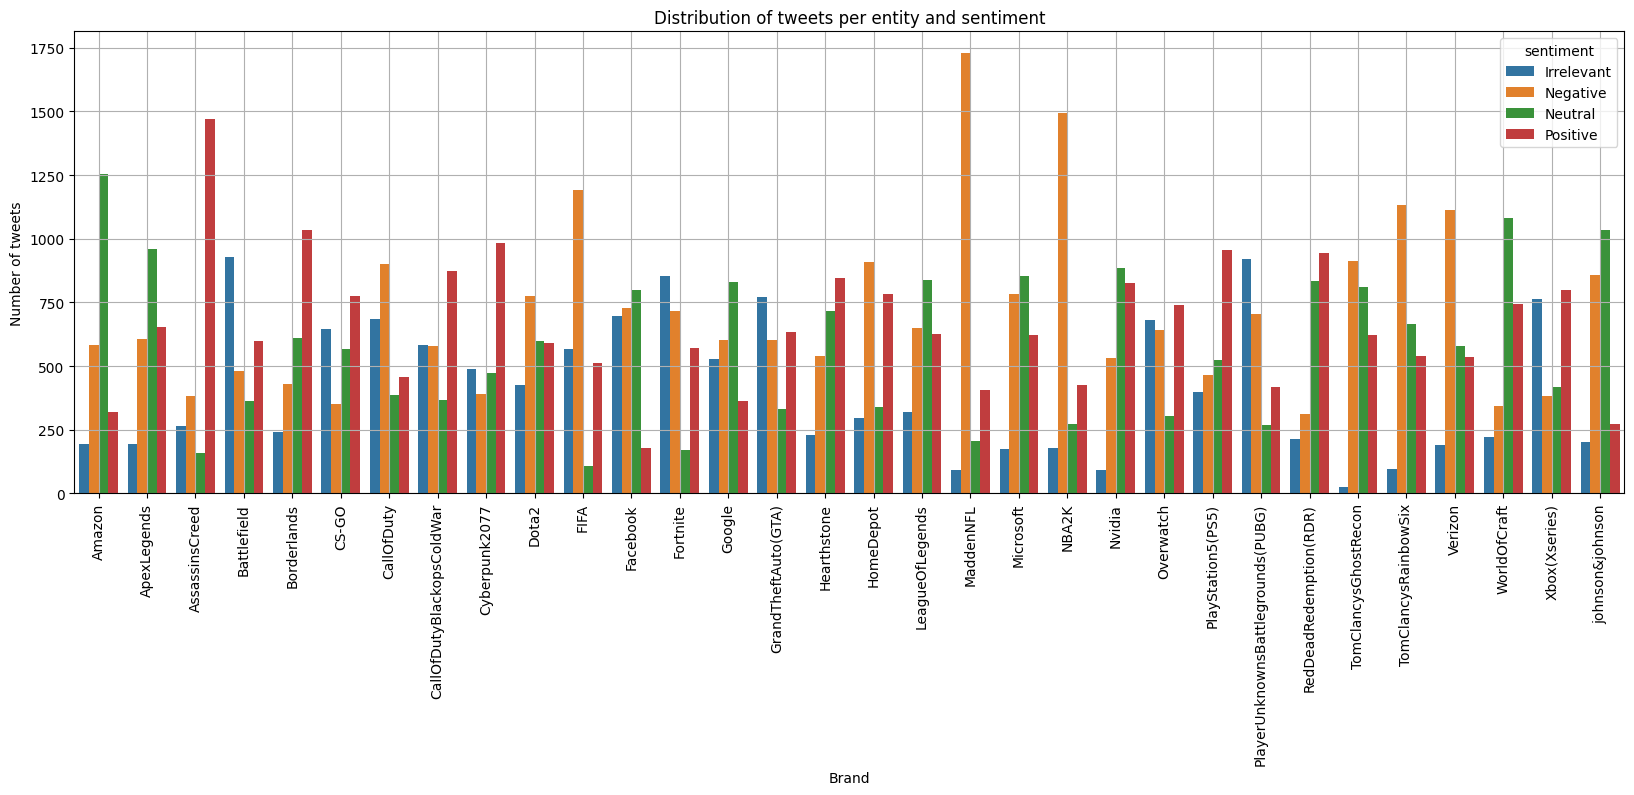

In [10]:
plt.figure(figsize=(20,6))
sns.barplot(data=plt_df, x="entity",y="count", hue="sentiment")
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per entity and sentiment");

# Creating models

## Digitalizing the data

In [11]:
reviews_train, reviews_test = train_test_split(df, test_size=0.2, random_state=9)

vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(reviews_train['text'])
X_test = vectorizer.transform(reviews_test['text'])

y_train = reviews_train["sentiment"]
y_test = reviews_test["sentiment"]

print(f"Unique tokens count: {len(vectorizer.get_feature_names_out())}")

Unique tokens count: 38525


> Notes:
> - first we need to split our dataframe into training and testing datasets
> - training data was used to create `CountVectorizer` (with its default values) that is going to digitalize our data
> - in this take we are dealing with unigrams only (sequences of only one word)
> - our dictionary consists of almost 40k words

## Training the model

In [12]:
model = LogisticRegression(max_iter=200)

model.fit(X_train, y_train)
model.score(X_test, y_test)

/home/kamil/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.8284223044397463

> Notes:
> - the model was created using `LogisitcRegression` with the maximum number of `lbfgs` algorithm iterations being `200`
> - final model score is quite high but not perfect

## Most imortant words in each class

In [13]:
# helper function to retrieve the most significant words of the givent sentiment
def get_significant_words(category, vocabulary, coefs):
    return np.array(sorted(list(zip(vocabulary, coefs[category])), key= lambda x:x[1], reverse=True))

In [14]:
print(">>> model classes")
words = vectorizer.get_feature_names_out()

for i, model_class in zip(range(len(model.classes_)), model.classes_):
    print(f"The most {model_class} words")
    for word in get_significant_words(i, words, model.coef_)[:10]:
        print(f"> {word}")

>>> model classes
The most Irrelevant words
> ['ti' '2.444125921959589']
> ['montage' '2.3442534719216015']
> ['vinland' '2.3036101922908983']
> ['occurred' '2.208907605382536']
> ['zayn' '2.183770006774489']
> ['shuttin' '2.1407017799586825']
> ['peasants' '2.12501225201311']
> ['mindofmercy' '2.0891422464254656']
> ['liverpool' '2.0706926215940964']
> ['jota' '2.0436290422432895']
The most Negative words
> ['homedepot' '2.571125998280669']
> ['confusing' '2.5607386844624798']
> ['postpartum' '2.325002005254007']
> ['eamaddennfl' '2.320223097057953']
> ['superbly' '2.298330041055284']
> ['plague' '2.127934124519562']
> ['sucks' '2.1206284756809253']
> ['matchmaking' '2.076368354324106']
> ['2ksupport' '2.071571582963738']
> ['playoverwatch' '2.057335449125797']
The most Neutral words
> ['patriot' '2.324647785919477']
> ['homies' '2.288787218535341']
> ['modernwarzone' '2.142290105726865']
> ['diamond' '2.065624547374745']
> ['panic' '2.0578295099611434']
> ['rounds' '1.961826875160860

> Notes:
> - assigning words to each category doesn't seem very obvious
> - seeing the most positive and negative words we can understand why deleting not existing words (which could be easily done with the help of nltk library) would ruin our model performance
> - list of the most negative words contains words such as `homedeepot`, `eamaddennfl`, `2ksupport` or `playoverwatch` which are profile names of big companies
> - at first glance we cannot tell much about words assigned to neutral and irrelevant category
> - positive words does not seem to make sense 

## Better model using ngrams
Often in sentiment analysis, the combination of words in a phrase can convey a sentiment that may not be evident when looking at individual words alone. By default `CountVectorizer` can create only dictionaries consisting of single words but we can force it to use combination of different words.

In [15]:
second_vectorizer = CountVectorizer(ngram_range=(1, 4))
X_train = second_vectorizer.fit_transform(reviews_train['text'])
X_test = second_vectorizer.transform(reviews_test['text'])

In [16]:
print(len(second_vectorizer.get_feature_names_out()))

1399262


> Notes:
> - now the dictionary consists of not only single words but also bigrams, trigrams or 4-grams
> - size of the dictionary has increased from almost 40k to over 1 million entires

In [17]:
second_model = LogisticRegression(max_iter=200)
second_model.fit(X_train, y_train)

/home/kamil/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=200)

In [18]:
print(second_model.score(X_test, y_test))

0.8917811839323467


> Notes:
> - as we can see the second model performs better than the previous one
> - it took much more time to train the mode (12s vs 250s)

### Sginificant words in the newer model

Now let's see whether significant words returned by the model have changed or not

In [19]:
print("Most Negative words")
for word in get_significant_words(1, second_vectorizer.get_feature_names_out(), second_model.coef_)[:10]:
    print(word)
print("Most Positive words")
for word in get_significant_words(3, second_vectorizer.get_feature_names_out(), second_model.coef_)[:10]:
    print(word) 

Most Negative words
['eamaddennfl' '2.153852948674375']
['sucks' '1.933745728437897']
['fix' '1.8307717147115103']
['nba2k' '1.8284617464128412']
['wtf' '1.7340532974038638']
['fuck' '1.6785504883495197']
['trash' '1.6636497704901088']
['smh' '1.6432906947792059']
['lame' '1.586979764100143']
['garbage' '1.5647016462462873']
Most Positive words
['wow' '2.366872157109339']
['woah' '1.9901037982763312']
['beautiful' '1.8972427025425693']
['nice' '1.8435779455050416']
['interesting' '1.814296587391229']
['excited' '1.7862331749753788']
['cool' '1.765956795625']
['fun' '1.7266195214317706']
['congratulations' '1.657844907601853']
['love' '1.6150456022185133']


> Notes:
> - as we can see positive and negative words have changed with the newer model and they seem to be more relevant 
> - i haven't printed out words assigned to the irrelevant or neutral category because it is not possible to judge whether it was classfied correctly or not
> - all significant words fit perfectly to their categories (besides `eamaddennfl` and `nba2k`)
> - it is a huge difference compared to the previous model which was only a bit less performant 

### Representative tweets in each sentiment category
Now, let's observe how our model performs when predicting the sentiment of reviews from the test dataset.

In [20]:
probability = second_model.predict_proba(X_test)
classes = second_model.classes_

for i, model_class in zip(range(len(classes)), classes):
    prob_text_pair = list(zip(reviews_test["text"], probability[:,i]))
    sorted_pairs = sorted(prob_text_pair, key= lambda x:x[1], reverse=True)
    print(f"The most {model_class} tweets:")
    for tweet in sorted_pairs[:5]:
        print(f"> {tweet}")

The most Irrelevant tweets:
> ('Ban for Battlefield 4 player LUVKY1234556 has occurred SEE DETAILS bf4dbcom  player  ban  100', 0.9999999698094522)
> ('A ban for Battlefield 4 player Strike0xD has occurred SEE DETAILS bf4dbcom  player  ban  100', 0.9999999667146975)
> ('Ban for Battlefield 4 player mertjoker1831 has occurred SEE DETAILS bf4dbcom  player  ban  100', 0.9999999649054739)
> ('Ban for Battlefield 4 player Shyphow has occurred SEE DETAILS bf4dbcom  player  ban  100', 0.9999999641925437)
> ('A ban for Battlefield 4 player 5i1ent has occurred SEE DETAILS bf4dbcom  player  ban  100', 0.999999962527297)
The most Negative tweets:
> ('EAMaddenNFL FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU FUCK YOU U GUYS FUCKING LIE TO US GO FUCK UR NO LIFE SELVES', 0.9999999990941753)
> ('Treyarch Call of Duty Black Ops 3 is the worst fucking game ever The game board is already ruined completely by the glitch class havin ass losers Fix the perfect fucking game Can ’ t go into a damn single matc

> Notes:
> - most of the irrelevant tweets were written by players who were banned in the Battlefield 4 game, and there is nothing interesting to see here; it seems like all these messages fit into the given category.
> - in the case of negative reviews, we can observe many strong words and swears, which categorize them accordingly
> - neutral reviews don't contain any interesting information, and it seems like these tweets were not written by a human being
> - when it comes to tweets classified as positive, it appears that all of them fit their place.

# Model with limited vocabulary

Having the previous model we can deduce a limited vocabulary to create a smaller and faster model. To achieve this goal I decided to limit the data to only positive and negative reviews (all negative and irrelevant rows were dropped). Vocabulary used in the model was created out of 20 most positive and negative words. 

In [21]:
wordset = second_vectorizer.get_feature_names_out()
significant_words = []
print(second_model.classes_)
most_positive = get_significant_words(3, wordset, second_model.coef_)[:,0][:20]
most_negative = get_significant_words(1, wordset, second_model.coef_)[:,0][:20]

significant_words.extend(most_positive)
significant_words.extend(most_negative)
print(significant_words)

['Irrelevant' 'Negative' 'Neutral' 'Positive']
['wow', 'woah', 'beautiful', 'nice', 'interesting', 'excited', 'cool', 'fun', 'congratulations', 'love', 'respect', 'wait', 'awesome', 'thank', 'loving', 'hyped', 'dope', 'salute', 'neat', 'amazing', 'eamaddennfl', 'sucks', 'fix', 'nba2k', 'wtf', 'fuck', 'trash', 'smh', 'lame', 'garbage', 'servers', 'rainbow6game', 'miss pubg', 'hate', 'dumbasses', 'rip', 'disrespect', 'shit', 'bruhhh', 'stupidity']


In [22]:
df = df.drop(df[(df['sentiment'] == 'Neutral')].index)
df = df.drop(df[(df['sentiment'] == 'Irrelevant')].index)
df['sentiment'].unique()

array(['Positive', 'Negative'], dtype=object)

In [23]:
train, test = train_test_split(df, random_state=9, test_size=0.2)

vectorizer = CountVectorizer(vocabulary=significant_words)

X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])

y_train = train['sentiment']
y_test = test['sentiment']

In [24]:
new_model = LogisticRegression()
new_model.fit(X_train, y_train)

print(new_model.score(X_test, y_test))

0.6616575591985429


> Notes:
> - the model with limited wordset performs significantly worse than the previous ones but is not disappointing either
> - its dictionary consists only of 40 words instead of over 1 million hence its evaluation was quick

In [25]:
for word, coef in zip(vectorizer.get_feature_names_out(), new_model.coef_[0]):
    print(f"{word}: {coef}")

wow: 1.4744258320633776
woah: 2.0039075025897923
beautiful: 2.5107702193100563
nice: 1.9610386718004027
interesting: 2.11495137511238
excited: 2.66080306918001
cool: 2.027704776036845
fun: 1.8254863310475675
congratulations: 2.014743783857301
love: 2.0063769452953313
respect: 1.1777815470716375
wait: 1.4961726733139122
awesome: 1.951427006374343
thank: 2.045503964000261
loving: 2.881740686391717
hyped: 1.8768472271462673
dope: 2.678971715834625
salute: 1.7013026443714176
neat: 1.2643326869063587
amazing: 2.034768280985524
eamaddennfl: -2.0255642201955375
sucks: -2.5613864572516505
fix: -2.8720057834831083
nba2k: -1.612840362635157
wtf: -1.5142754150215867
fuck: -1.1228535683773095
trash: -1.9279889954650082
smh: -1.6936861124406597
lame: -1.0509373488030516
garbage: -1.5274496308653471
servers: -1.9555320786032604
rainbow6game: -1.6156681406646516
miss pubg: 0.0
hate: -1.4795820589678648
dumbasses: -1.4334832062349174
rip: -1.6539996391475047
disrespect: -1.6580211884803153
shit: -1.02

> Notes: 
> - we can also examine the significance of individual words in the model.
> - as we can see, the order of importance for these words has changed in this model compared to the previous (and most accurate) one

### Finally, let's check how would the full model behave compared to the small one

In [26]:
vectorizer = CountVectorizer()
X_train = vectorizer.fit_transform(train['text'])
X_test = vectorizer.transform(test['text'])

new_model = LogisticRegression()
new_model.fit(X_train, y_train)

print(new_model.score(X_test, y_test), f"with dictionary size: {len(vectorizer.get_feature_names_out())}")

0.9146174863387978 with dictionary size: 22072


/home/kamil/.local/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


> Notes:
> - no surprise here that the model with a vocabulary 552 times larger would outperform the other